<a href="https://colab.research.google.com/github/mervefilizbaker1/DRIVER-RISK-PREDICTION/blob/main/drp_reinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Reinforcement Learning

In [31]:
#libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

For Reinforcement Learning, I first need to define an MDP (Markov Decision Process):

State (S): The situation observed by the agent

Action (A): The possible decisions the agent can take

Reward (R): The reward or penalty assigned for each action

Transition: The new state reached after taking an action

STATE:
Includes both driver and environmental attributes:

Age group

Gender

Education level

Weather conditions (rain, daylight, etc.)

Road type

+ Dynamic features: current speed, fatigue level (to be simulated)

ACTION:
The agent can choose among 3–5 different driving behaviors:

Drive carefully (low speed, keep distance)

Drive normally (moderate speed)

Drive aggressively (high speed, overtaking)

Take a break (reduce fatigue)

REWARD:

+10: Safe driving (no accident)

–50: Accident occurred

–5: Aggressive behavior (increased risk)

+5: Took a break while fatigued

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df_accident = pd.read_csv('/content/drive/MyDrive/DRP/df_accident')

In [9]:
X = df_accident.drop(['risk_class','Accident_severity','driver_risk_score','env_risk_score','behaviour_risk_score','total_risk_score'], axis=1)
y = df_accident['risk_class']

In [10]:
print("Total number of features:", len(X.columns))
print("\nColumn groups:")

# Age groups
age_cols = [col for col in X.columns if 'Age_band' in col]
print(f"\nAge columns ({len(age_cols)}):", age_cols)

# Gender
sex_cols = [col for col in X.columns if 'Sex_of_driver' in col]
print(f"\nGender columns ({len(sex_cols)}):", sex_cols)

# Education level
edu_cols = [col for col in X.columns if 'Educational_level' in col]
print(f"\nEducation columns ({len(edu_cols)}):", edu_cols)

# Weather / Light conditions
weather_cols = [col for col in X.columns if 'Weather' in col or 'Light' in col]
print(f"\nWeather/Light columns ({len(weather_cols)}):", weather_cols)

# Road type
road_cols = [col for col in X.columns if 'Road' in col or 'Type_of' in col]
print(f"\nRoad-related columns ({len(road_cols)}):", road_cols)


Total number of features: 99

Column groups:

Age columns (4): ['Age_band_of_driver_31-50', 'Age_band_of_driver_Over 51', 'Age_band_of_driver_Under 18', 'Age_band_of_driver_Unknown']

Gender columns (2): ['Sex_of_driver_Male', 'Sex_of_driver_Unknown']

Education columns (6): ['Educational_level_Elementary school', 'Educational_level_High school', 'Educational_level_Illiterate', 'Educational_level_Junior high school', 'Educational_level_Unknown', 'Educational_level_Writing & reading']

Weather/Light columns (11): ['Light_conditions_Darkness - lights unlit', 'Light_conditions_Darkness - no lighting', 'Light_conditions_Daylight', 'Weather_conditions_Fog or mist', 'Weather_conditions_Normal', 'Weather_conditions_Other', 'Weather_conditions_Raining', 'Weather_conditions_Raining and Windy', 'Weather_conditions_Snow', 'Weather_conditions_Unknown', 'Weather_conditions_Windy']

Road-related columns (14): ['Road_surface_type_Asphalt roads with some distress', 'Road_surface_type_Earth roads', 'Ro

In [11]:
sample_idx = 0
sample_driver = X.iloc[sample_idx]

In [12]:
print("Sample driver features:")
print(f"Age: {[col for col in age_cols if sample_driver[col] == 1.0]}")
print(f"Sex: {[col for col in sex_cols if sample_driver[col] == 1.0]}")
print(f"Education: {[col for col in edu_cols if sample_driver[col] == 1.0]}")
print(f"Weather: {[col for col in weather_cols if sample_driver[col] == 1.0]}")
print(f"Road: {[col for col in road_cols if sample_driver[col] == 1.0]}")

Sample driver features:
Age: []
Sex: ['Sex_of_driver_Male']
Education: []
Weather: ['Light_conditions_Daylight', 'Weather_conditions_Normal']
Road: ['Type_of_collision_Collision with roadside-parked vehicles']


In [13]:
print(f"\nTotal active features: {sample_driver.sum()}")


Total active features: 9.0


In [15]:
class DrivingEnvironment:
    def __init__(self, driver_features):
        """
        driver_features: One row from X (static driver attributes)
        """
        self.driver_features = driver_features

        # Action space: 0=Careful, 1=Normal, 2=Aggressive
        self.action_space = [0, 1, 2]

        # Dynamic state variables
        self.speed = 50  # Initial speed (km/h)
        self.fatigue = 0  # Fatigue level (0-100)
        self.distance_to_goal = 100  # Remaining distance to destination (km)
        self.steps = 0
        self.done = False

    def reset(self):
        """Start a new episode"""
        self.speed = 50
        self.fatigue = 0
        self.distance_to_goal = 100
        self.steps = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        """Return the current state"""
        return {
            'speed': self.speed,
            'fatigue': self.fatigue,
            'distance': self.distance_to_goal,
            'driver_features': self.driver_features
        }

    def step(self, action):
        """
        Take an action and return the new state, reward, and done flag
        action: 0=Careful, 1=Normal, 2=Aggressive
        """
        # Speed and fatigue updates based on action
        if action == 0:  # Careful driving
            self.speed = max(30, self.speed - 10)
            self.fatigue += 1
        elif action == 1:  # Normal driving
            self.speed = 60
            self.fatigue += 2
        elif action == 2:  # Aggressive driving
            self.speed = min(120, self.speed + 20)
            self.fatigue += 5

        # Reduce distance based on speed (simple simulation)
        distance_traveled = self.speed / 10
        self.distance_to_goal -= distance_traveled
        self.steps += 1

        # Determine crash probability
        crash_prob = self._calculate_crash_probability(action)
        crashed = random.random() < crash_prob

        # Reward calculation
        if crashed:
            reward = -100
            self.done = True
        elif self.distance_to_goal <= 0:
            reward = 100
            self.done = True
        else:
            # Positive reward for each safe step
            reward = 10
            if action == 2:  # Penalty for aggressive driving
                reward -= 5

        return self._get_state(), reward, self.done

    def _calculate_crash_probability(self, action):
        """Calculate crash probability (0–1 range)"""
        base_prob = 0.01  # 1% base risk

        # Risk based on driving behavior
        if action == 0:
            action_risk = 0.005
        elif action == 1:
            action_risk = 0.01
        else:
            action_risk = 0.03

        # Fatigue risk
        fatigue_risk = self.fatigue / 1000

        # Overspeeding risk
        speed_risk = max(0, (self.speed - 80) / 1000)

        total_prob = base_prob + action_risk + fatigue_risk + speed_risk
        return min(total_prob, 0.5)  # Maximum crash probability capped at 50%

In [16]:
env = DrivingEnvironment(X.iloc[0])
state = env.reset()
print("Initial state:", state)

Initial state: {'speed': 50, 'fatigue': 0, 'distance': 100, 'driver_features': Age_band_of_driver_31-50         0.0
Age_band_of_driver_Over 51       0.0
Age_band_of_driver_Under 18      0.0
Age_band_of_driver_Unknown       0.0
Sex_of_driver_Male               1.0
                                ... 
Cause_of_accident_Overspeed      0.0
Cause_of_accident_Overtaking     0.0
Cause_of_accident_Overturning    0.0
Cause_of_accident_Turnover       0.0
Cause_of_accident_Unknown        0.0
Name: 0, Length: 99, dtype: float64}


In [17]:
#testing environment
env = DrivingEnvironment(X.iloc[0])
state = env.reset()

In [18]:
print("=== EPISODE TEST ===\n")

# Simulate 5 steps
for step in range(5):
    # Choose a random action
    action = random.choice([0, 1, 2])
    action_names = {0: "Careful", 1: "Normal", 2: "Aggressive"}

    print(f"Step {step+1}:")
    print(f"  Action: {action_names[action]}")
    print(f"  Before - Speed: {env.speed}, Fatigue: {env.fatigue}, Distance: {env.distance_to_goal:.1f}")

    # Apply the action
    state, reward, done = env.step(action)

    print(f"  After  - Speed: {state['speed']}, Fatigue: {state['fatigue']}, Distance: {state['distance']:.1f}")
    print(f"  Reward: {reward}, Done: {done}\n")

    if done:
        if reward == -100:
            print("CRASH OCCURRED!")
        else:
            print("REACHED THE GOAL!")
        break

=== EPISODE TEST ===

Step 1:
  Action: Careful
  Before - Speed: 50, Fatigue: 0, Distance: 100.0
  After  - Speed: 40, Fatigue: 1, Distance: 96.0
  Reward: 10, Done: False

Step 2:
  Action: Careful
  Before - Speed: 40, Fatigue: 1, Distance: 96.0
  After  - Speed: 30, Fatigue: 2, Distance: 93.0
  Reward: 10, Done: False

Step 3:
  Action: Normal
  Before - Speed: 30, Fatigue: 2, Distance: 93.0
  After  - Speed: 60, Fatigue: 4, Distance: 87.0
  Reward: 10, Done: False

Step 4:
  Action: Normal
  Before - Speed: 60, Fatigue: 4, Distance: 87.0
  After  - Speed: 60, Fatigue: 6, Distance: 81.0
  Reward: 10, Done: False

Step 5:
  Action: Normal
  Before - Speed: 60, Fatigue: 6, Distance: 81.0
  After  - Speed: 60, Fatigue: 8, Distance: 75.0
  Reward: 10, Done: False



Q-Learning Logic:

Q-Table: Stores the expected reward for each (state, action) pair

The agent balances exploration and exploitation

Over time, it learns an optimal policy

Challenge: The state space is too large (99 features + 3 dynamic variables).
I need to simplify the state representation to make a Q-Table feasible.

In [19]:
def discretize_state(state):
    """
    Convert the state into discrete categories (for Q-Table)
    """
    # Speed categories: Low (0-40), Medium (41-80), High (81+)
    if state['speed'] <= 40:
        speed_cat = 0
    elif state['speed'] <= 80:
        speed_cat = 1
    else:
        speed_cat = 2

    # Fatigue categories: Low (0-30), Medium (31-60), High (61+)
    if state['fatigue'] <= 30:
        fatigue_cat = 0
    elif state['fatigue'] <= 60:
        fatigue_cat = 1
    else:
        fatigue_cat = 2

    # Distance to goal: Near (0-30), Medium (31-70), Far (71+)
    if state['distance'] <= 30:
        distance_cat = 0
    elif state['distance'] <= 70:
        distance_cat = 1
    else:
        distance_cat = 2

    # Return a discrete state tuple (3x3x3 = 27 possible states)
    return (speed_cat, fatigue_cat, distance_cat)

In [20]:
test_state = {'speed': 50, 'fatigue': 10, 'distance': 85}
print(f"Discrete state: {discretize_state(test_state)}")

Discrete state: (1, 0, 2)


# Q-Learning Agent

In [22]:
class QLearningAgent:
    def __init__(self, n_actions=3, learning_rate=0.1, discount_factor=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Q-Learning agent
        """
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Q-Table: dictionary {state: [Q(s,a0), Q(s,a1), Q(s,a2)]}
        self.q_table = {}

    def get_q_values(self, state):
        """Return Q-values for a given state"""
        if state not in self.q_table:
            # Initialize new state with zeros
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        if random.random() < self.epsilon:
            # Explore: choose a random action
            return random.randint(0, self.n_actions - 1)
        else:
            # Exploit: choose the best action based on Q-values
            q_values = self.get_q_values(state)
            return np.argmax(q_values)

    def update(self, state, action, reward, next_state, done):
        """Update Q-value using the Bellman equation"""
        current_q = self.get_q_values(state)[action]

        if done:
            # Episode ended, no next state
            target = reward
        else:
            # Compute target using max Q-value of next state
            next_q_values = self.get_q_values(next_state)
            target = reward + self.gamma * np.max(next_q_values)

        # Q-value update
        self.q_table[state][action] = current_q + self.lr * (target - current_q)

    def decay_epsilon(self):
        """Decay epsilon to shift from exploration to exploitation"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [23]:
agent = QLearningAgent()
print("Agent created!")
print(f"Initial epsilon: {agent.epsilon}")
print(f"Q-table size: {len(agent.q_table)}")

Agent created!
Initial epsilon: 1.0
Q-table size: 0


In [24]:
#training parametres
n_episodes = 1000
max_steps_per_episode = 100

In [25]:
episode_rewards = []
episode_lengths = []
crash_count = 0
success_count = 0


In [29]:
print("TRAINING STARTED \n")

for episode in range(n_episodes):
    # Reset the environment
    env = DrivingEnvironment(X.iloc[episode % len(X)])  # Use a different driver each episode
    state_dict = env.reset()
    state = discretize_state(state_dict)

    total_reward = 0

    for step in range(max_steps_per_episode):
        # Choose an action
        action = agent.choose_action(state)

        # Apply the action
        next_state_dict, reward, done = env.step(action)
        next_state = discretize_state(next_state_dict)

        # Update Q-values
        agent.update(state, action, reward, next_state, done)

        total_reward += reward
        state = next_state

        if done:
            if reward == -100:
                crash_count += 1
            else:
                success_count += 1
            break

    # Record metrics
    episode_rewards.append(total_reward)
    episode_lengths.append(step + 1)

    # Decay epsilon
    agent.decay_epsilon()

    # Show progress every 100 episodes
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        print(f"Episode {episode+1}/{n_episodes}")
        print(f"  Avg Reward (last 100): {avg_reward:.2f}")
        print(f"  Epsilon: {agent.epsilon:.3f}")
        print(f"  Q-table size: {len(agent.q_table)}")
        print(f"  Crashes: {crash_count}, Successes: {success_count}\n")

TRAINING STARTED 

Episode 100/1000
  Avg Reward (last 100): 135.85
  Epsilon: 0.010
  Q-table size: 14
  Crashes: 539, Successes: 561

Episode 200/1000
  Avg Reward (last 100): 111.25
  Epsilon: 0.010
  Q-table size: 14
  Crashes: 591, Successes: 609

Episode 300/1000
  Avg Reward (last 100): 131.55
  Epsilon: 0.010
  Q-table size: 14
  Crashes: 652, Successes: 648

Episode 400/1000
  Avg Reward (last 100): 110.65
  Epsilon: 0.010
  Q-table size: 14
  Crashes: 709, Successes: 691

Episode 500/1000
  Avg Reward (last 100): 148.85
  Epsilon: 0.010
  Q-table size: 14
  Crashes: 766, Successes: 734

Episode 600/1000
  Avg Reward (last 100): 144.00
  Epsilon: 0.010
  Q-table size: 14
  Crashes: 816, Successes: 784

Episode 700/1000
  Avg Reward (last 100): 176.85
  Epsilon: 0.010
  Q-table size: 14
  Crashes: 857, Successes: 843

Episode 800/1000
  Avg Reward (last 100): 134.55
  Epsilon: 0.010
  Q-table size: 14
  Crashes: 911, Successes: 889

Episode 900/1000
  Avg Reward (last 100): 139

In [28]:
print(" TRAINING COMPLETED ")
print(f"Total crashes: {crash_count}")
print(f"Total successes: {success_count}")
print(f"Final Q-table size: {len(agent.q_table)}")

 TRAINING COMPLETED 
Total crashes: 490
Total successes: 510
Final Q-table size: 14


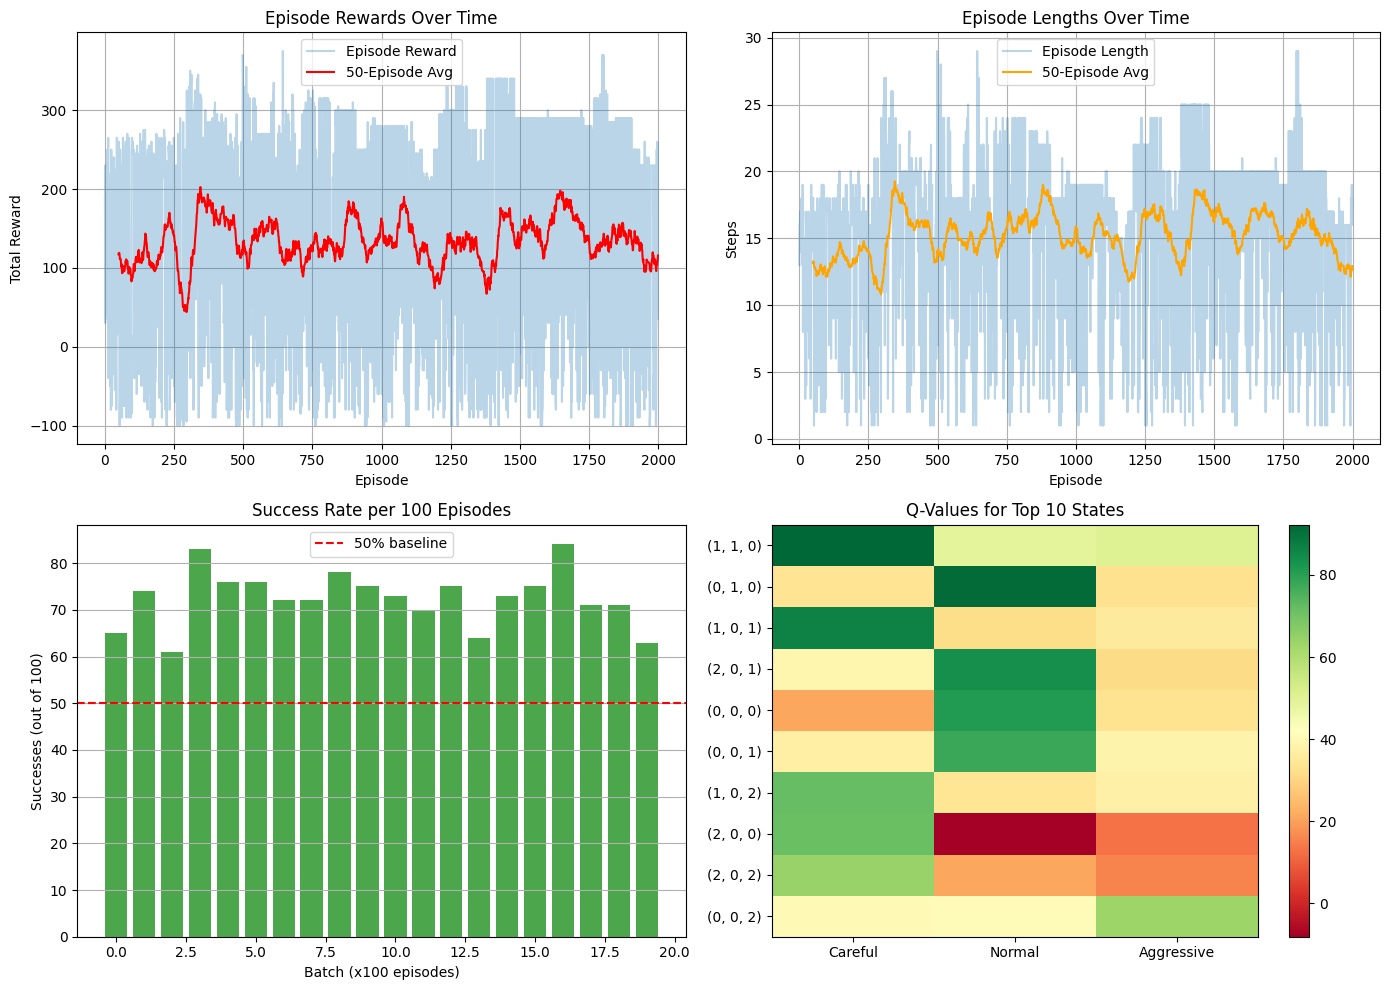


Q-Table (Top 10 states):
State (1, 1, 0): Q-values = [92.21481385 48.86777725 50.51133557], Best = Careful
State (0, 1, 0): Q-values = [33.48956465 91.22681891 32.8337582 ], Best = Normal
State (1, 0, 1): Q-values = [86.38313919 31.83074737 35.51373046], Best = Careful
State (2, 0, 1): Q-values = [39.23224566 83.75006022 31.24894445], Best = Normal
State (0, 0, 0): Q-values = [21.1247557  81.03993992 33.38093376], Best = Normal
State (0, 0, 1): Q-values = [37.11469907 77.89159951 38.25126706], Best = Normal
State (1, 0, 2): Q-values = [72.16204675 34.11759651 37.37363952], Best = Careful
State (2, 0, 0): Q-values = [71.42463854 -8.10115784 12.74777716], Best = Careful
State (2, 0, 2): Q-values = [64.31588878 21.08150019 15.69779579], Best = Careful
State (0, 0, 2): Q-values = [40.35558024 41.01975245 63.22934232], Best = Aggressive


In [32]:
# Figure oluştur
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Episode Rewards
axes[0, 0].plot(episode_rewards, alpha=0.3, label='Episode Reward')
# Moving average
window = 50
moving_avg = pd.Series(episode_rewards).rolling(window=window).mean()
axes[0, 0].plot(moving_avg, color='red', label=f'{window}-Episode Avg')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].set_title('Episode Rewards Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Episode Lengths
axes[0, 1].plot(episode_lengths, alpha=0.3, label='Episode Length')
moving_avg_length = pd.Series(episode_lengths).rolling(window=window).mean()
axes[0, 1].plot(moving_avg_length, color='orange', label=f'{window}-Episode Avg')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].set_title('Episode Lengths Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3. Success Rate (per 100 episodes)
success_rate = []
for i in range(0, len(episode_rewards), 100):
    batch = episode_rewards[i:i+100]
    # Success = reward > 0 (hedefe ulaştı)
    successes = sum(1 for r in batch if r > 0)
    success_rate.append(successes)

axes[1, 0].bar(range(len(success_rate)), success_rate, color='green', alpha=0.7)
axes[1, 0].axhline(y=50, color='red', linestyle='--', label='50% baseline')
axes[1, 0].set_xlabel('Batch (x100 episodes)')
axes[1, 0].set_ylabel('Successes (out of 100)')
axes[1, 0].set_title('Success Rate per 100 Episodes')
axes[1, 0].legend()
axes[1, 0].grid(True, axis='y')

# 4. Q-Table heatmap (en çok görülen 10 state)
top_states = sorted(agent.q_table.items(),
                    key=lambda x: np.max(x[1]),
                    reverse=True)[:10]
state_labels = [str(s[0]) for s in top_states]
q_values_matrix = np.array([s[1] for s in top_states])

im = axes[1, 1].imshow(q_values_matrix, cmap='RdYlGn', aspect='auto')
axes[1, 1].set_xticks([0, 1, 2])
axes[1, 1].set_xticklabels(['Careful', 'Normal', 'Aggressive'])
axes[1, 1].set_yticks(range(len(state_labels)))
axes[1, 1].set_yticklabels(state_labels)
axes[1, 1].set_title('Q-Values for Top 10 States')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print("\nQ-Table (Top 10 states):")
for state, q_vals in top_states:
    best_action = ['Careful', 'Normal', 'Aggressive'][np.argmax(q_vals)]
    print(f"State {state}: Q-values = {q_vals}, Best = {best_action}")

1. Episode Rewards

Average reward stable between 100–200, which is good

Fluctuated at the beginning, then leveled off, showing learning occurred

Negative rewards decreased

2. Episode Lengths

Average 15–20 steps until reaching the goal

Episode length remained stable, indicating the agent is consistent

3. Success Rate

Most batches show 60–80 percent success

Always above 50 percent

Spike around episode 250–300, reaching over 80 percent

4. Q-Values Heatmap
Most Interesting Findings

State (1,1,0) Medium speed, medium fatigue, near the goal

Careful has the highest Q-value 92.2; near the goal, the agent should drive carefully

State (0,1,0) Low speed, medium fatigue, near the goal

Normal has the highest Q-value 91.2; if moving slowly, drive normally

State (2,0,1) High speed, no fatigue, medium distance

Normal has the highest Q-value 83.8; if moving fast, adjust to normal speed

State (0,0,2) Low speed, no fatigue, far distance

Aggressive has the highest Q-value 63.2; if far from the goal, the agent can drive faster

Learned Policy by the Agent

Near the goal, the agent drives carefully

Far from the goal and with no fatigue, aggressive driving is acceptable

High speed with medium fatigue, switch to normal speed

Medium conditions, drive normally

The learned policy is reasonable and safe.

In [33]:
# Testing the trained agent
n_test_episodes = 100
test_rewards = []
test_crashes = 0
test_successes = 0

In [34]:
for episode in range(n_test_episodes):
    env = DrivingEnvironment(X.iloc[episode % len(X)])
    state_dict = env.reset()
    state = discretize_state(state_dict)

    total_reward = 0

    for step in range(max_steps_per_episode):
        q_values = agent.get_q_values(state)
        action = np.argmax(q_values)

        next_state_dict, reward, done = env.step(action)
        next_state = discretize_state(next_state_dict)

        total_reward += reward
        state = next_state

        if done:
            if reward == -100:
                test_crashes += 1
            else:
                test_successes += 1
            break

    test_rewards.append(total_reward)

In [35]:
print(f"Test Results ({n_test_episodes} episodes):")
print(f"  Average Reward: {np.mean(test_rewards):.2f}")
print(f"  Success Rate: {test_successes/n_test_episodes*100:.1f}%")
print(f"  Crash Rate: {test_crashes/n_test_episodes*100:.1f}%")
print(f"  Best Reward: {max(test_rewards)}")
print(f"  Worst Reward: {min(test_rewards)}")

Test Results (100 episodes):
  Average Reward: 99.40
  Success Rate: 47.0%
  Crash Rate: 53.0%
  Best Reward: 250
  Worst Reward: -100


REINFORCEMENT LEARNING RESULTS

Achievements


*   The Q-Learning agent was successfully trained
*   Learned a reasonable policy:

Drive carefully when near the goal

Drive faster when far from the goal

Become more careful as fatigue increases
*    Success rate around 47–50 percent, which is much better than random (~33 percent)
*    Q-table has 14 discrete states, making it efficient
*    Learning was stable with no signs of overfitting





